## Lab 7 - Using Machine Learning for Intrusion Detection

This Lab exercise will guide you through an example of using a machine learning (ML) algorithm to train a model for intrusion detection. You have been provided with this Notebook with markdown explanations & code used in this example, and a custom dataset that has been extracted from the NBaIoT dataset provided by UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT).

The provided dataset has labelled samples from benign traffic generated by a security camera (SimpleHome XCs7-1003-WHT) as well as traces when this camera is infected with Mirai botnet to launch a TCP SYN flooding attack. There are 115 features with one target class in the dataset. Details are in the following paper. 

[1] Y. Meidan, M. Bohadana, Y. Mathov, Y. Mirsky, D. Breitenbacher, A. Shabtai, and Y. Elovici "N-BaIoT: Network-based Detection of IoT Botnet Attacks Using Deep Autoencoders", IEEE Pervasive Computing, Special Issue - Securing the IoT (July/Sep 2018).

Attribute/Features Information:
The following describes each of the features headers:

- Stream aggregation:
   - H: ("Source IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP)
   - MI: ("Source MAC-IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP + MAC)
   - HH: ("Channel" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host (IP) to the packet's destination host.
   - HH_jit: ("Channel jitter" in N-BaIoT paper) Stats summarizing the jitter of the traffic going from this packet's host (IP) to the packet's destination host.
   - HpHp: ("Socket" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host+port (IP) to the packet's destination host+port. Example 192.168.4.2:1242 -> 192.168.4.12:80
- Time-frame (The decay factor Lambda used in the damped window): 
    - How much recent history of the stream is capture in these statistics (L5, L3, L1, L0.1 and L0.01)
- The statistics extracted from the packet stream:
   - weight: The weight of the stream (can be viewed as the number of items observed in recent history)
   - mean: ...
   - std: ...
   - radius: The root squared sum of the two streams' variances
   - magnitude: The root squared sum of the two streams' means 
   - cov: An approximated covariance between two streams
   - pcc: An approximated correlation coefficient between two streams


If you are interested in learning how these features have been extracted from the raw pcap (TCPDump or Wireshark captures), read the following paper. 

[2] Y. Mirsky, T. Doitshman, Y. Elovici & A. Shabtai 2018, "Kitsune: An Ensemble of Autoencoders for Online Network Intrusion Detection", in Network and Distributed System Security (NDSS) Symposium, San Diego, CA, USA. 

The example code in this notebook employs a simple supervised machine learning algorithm called K-Nearest Neighbor (k-NN) for classification purposes. The markdown text walks you through the ML pipeline required to train the model on the dataset, and evaluate its performance.  

You are required to create another Notebook by using a different ML algorithm called Decision Trees (DT - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You are to compare the results from using k-NN and DT on the provided dataset. Submit your DT notebook with narrative text explaining the following:

1. Compare the performance of k-NN and DT for the given classification task using accuracy, precision, recall, and latency as the metrics. 
2. Show the confusion matrix and the RoC curve 
3. Comment on performance of DT by using different values for hyperparameters (splitter, max_depth, min_samples_split, max_features) and split ratios (train:valid:test = 4:3:3, 3:1:1, 8:1:1). 

### Import Libraries, Modules and read the Dataset

In [218]:
import pandas as pd
import numpy as np   ### Support for large, multi-dimensional arrays and matrices. Has a large collection of high-level mathematical functions.
import matplotlib.pyplot as plt  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score
from time import time

dataset = pd.read_csv('FinalDataset.csv')

Lets have a peek at the dataset

In [219]:
dataset.head()
#gives the first five rows of data

MI_dir_L5_weight       MI_dir_L5_mean   MI_dir_L5_variance  \
0                1.000               74.000                0.000   
1                1.996               74.000                0.000   
2                2.984               74.000                0.000   
3                3.952               74.000                0.000   
4                4.931               74.000                0.000   

      MI_dir_L3_weight       MI_dir_L3_mean   MI_dir_L3_variance  \
0                1.000               74.000                0.000   
1                1.997               74.000                0.000   
2                2.990               74.000                0.000   
3                3.971               74.000                0.000   
4                4.959               74.000                0.000   

      MI_dir_L1_weight       MI_dir_L1_mean   MI_dir_L1_variance  \
0                1.000               74.000                0.000   
1                1.999               74.000                0.000   
2                2.997               74.000                0.000   
3                3.990               74.000                0.000   
4                4.986               74.000                0.000   

    MI_dir_L0.1_weight  ...  HpHp_L0.1_covariance        HpHp_L0.1_pcc  \
0                1.000  ...                 0.000                0.000   
1                2.000  ...                 0.000                0.000   
2                3.000  ...                 0.000                0.000   
3                3.999  ...                 0.000                0.000   
4                4.999  ...                 0.000                0.000   

     HpHp_L0.01_weight      HpHp_L0.01_mean       HpHp_L0.01_std  \
0                1.000               74.000                0.000   
1                1.000               74.000                0.000   
2                1.000               74.000                0.000   
3                1.000               74.000                0.000   
4                1.000               74.000                0.000   

   HpHp_L0.01_magnitude    HpHp_L0.01_radius  HpHp_L0.01_covariance  \
0                74.000                0.000                  0.000   
1                74.000                0.000                  0.000   
2                74.000                0.000                  0.000   
3                74.000                0.000                  0.000   
4                74.000                0.000                  0.000   

        HpHp_L0.01_pcc      Class  
0                0.000  Mirai_SYN  
1                0.000  Mirai_SYN  
2                0.000  Mirai_SYN  
3                0.000  Mirai_SYN  
4                0.000  Mirai_SYN  

[5 rows x 116 columns]

### Explore Features

In [220]:
dataset.info()# See the distribution of our target variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39056 entries, 0 to 39055
Columns: 116 entries, MI_dir_L5_weight to Class
dtypes: float64(115), object(1)
memory usage: 34.6+ MB


In [221]:
dataset['Class'].value_counts()  #check whether it is a balanced dataset or an imbalanced dataset

Mirai_SYN    19528
Benign       19528
Name: Class, dtype: int64

In [222]:
#Get an idea about the actual data distribution
pd.options.display.float_format = '{:20,.3f}'.format
dataset.describe()

MI_dir_L5_weight       MI_dir_L5_mean   MI_dir_L5_variance  \
count           39,056.000           39,056.000           39,056.000   
mean                70.569              145.774              151.178   
std                 72.909              119.313            1,770.355   
min                  1.000               60.000                0.000   
25%                  1.000               67.488                0.000   
50%                 21.300               72.242                4.996   
75%                136.877              330.000               37.087   
max                251.405              670.000           83,290.214   

          MI_dir_L3_weight       MI_dir_L3_mean   MI_dir_L3_variance  \
count           39,056.000           39,056.000           39,056.000   
mean               113.910              145.738              203.423   
std                115.984              119.088            1,982.480   
min                  1.000               60.000                0.000   
25%                  1.000               68.537                0.000   
50%                 21.641               71.610               14.184   
75%                224.669              330.000               38.027   
max                354.414              670.000           89,354.113   

          MI_dir_L1_weight       MI_dir_L1_mean   MI_dir_L1_variance  \
count           39,056.000           39,056.000           39,056.000   
mean               330.944              147.771              928.338   
std                332.315              116.868            2,945.813   
min                  1.000               60.000                0.000   
25%                  1.062               70.547                0.107   
50%                 22.570               71.586               34.982   
75%                662.818              329.999               42.857   
max                828.257              669.565           92,557.424   

        MI_dir_L0.1_weight  ...     HpHp_L0.1_radius  HpHp_L0.1_covariance  \
count           39,056.000  ...           39,056.000            39,056.000   
mean             3,029.858  ...            2,182.203               -24.576   
std              3,041.787  ...           16,463.431             2,001.900   
min                  1.000  ...                0.000           -37,601.681   
25%                  2.768  ...                0.000                 0.000   
50%                 49.960  ...                0.000                 0.000   
75%              6,201.298  ...                0.000                 0.000   
max              6,546.597  ...          480,808.295            69,895.058   

             HpHp_L0.1_pcc    HpHp_L0.01_weight      HpHp_L0.01_mean  \
count           39,056.000           39,056.000           39,056.000   
mean                -0.000                5.467              146.028   
std                  0.038               15.334              118.702   
min                 -0.587                1.000               60.000   
25%                  0.000                1.000               60.000   
50%                  0.000                1.000               74.000   
75%                  0.000                6.275              330.000   
max                  0.707              148.749              670.000   

            HpHp_L0.01_std  HpHp_L0.01_magnitude    HpHp_L0.01_radius  \
count           39,056.000            39,056.000           39,056.000   
mean                 2.912               191.321            2,759.261   
std                 16.897               179.734           22,582.172   
min                  0.000                60.000                0.000   
25%                  0.000                74.000                0.000   
50%                  0.000                74.000                0.000   
75%                  0.000               431.490                0.000   
max                220.179             1,265.998          454,622.861   

       HpHp_L0.01_covariance       HpHp_L0.01_pcc  
c

In [223]:
#Check whether there are null values
dataset.columns[dataset.isna().any()].tolist()
dataset.isnull().sum()

## Fill any null values with the Mean value of that feature. Should make sure that null is not a acceptable value for that feature.
# dataset['MI_dir_L5_weight'].fillna(dataset['MI_dir_L5_weight'].mean(), inplace=True)


MI_dir_L5_weight         0
MI_dir_L5_mean           0
MI_dir_L5_variance       0
MI_dir_L3_weight         0
MI_dir_L3_mean           0
                        ..
HpHp_L0.01_magnitude     0
HpHp_L0.01_radius        0
HpHp_L0.01_covariance    0
HpHp_L0.01_pcc           0
Class                    0
Length: 116, dtype: int64

In [224]:
#check for duplicates
# Select duplicate rows except first occurrence based on all columns
duplicates = dataset[dataset.duplicated()]
print(duplicates.count())

#Keep the first occurance 
# dataset.duplicated(subset=None, keep='first')

MI_dir_L5_weight         1592
MI_dir_L5_mean           1592
MI_dir_L5_variance       1592
MI_dir_L3_weight         1592
MI_dir_L3_mean           1592
                         ... 
HpHp_L0.01_magnitude     1592
HpHp_L0.01_radius        1592
HpHp_L0.01_covariance    1592
HpHp_L0.01_pcc           1592
Class                    1592
Length: 116, dtype: int64


### Split into train, validation, and test set

In [225]:
#shuffle the dataset
dataset = dataset.reindex(np.random.permutation(dataset.index))

In [226]:
#Separate Features and Labels
features = dataset.drop('Class', axis=1)
# features = dataset.iloc[:,50:80] #We can slice the dataframe and test with different feature combinations.
labels = dataset['Class']

In [227]:
features.head()

MI_dir_L5_weight       MI_dir_L5_mean   MI_dir_L5_variance  \
12242              192.724               71.051               32.590   
35339                1.000              330.000                0.000   
18042              129.677               73.672                4.516   
30872                1.961              330.000                0.000   
35443                1.000              330.000                0.000   

          MI_dir_L3_weight       MI_dir_L3_mean   MI_dir_L3_variance  \
12242              294.282               70.534               36.513   
35339                1.000              330.000                0.000   
18042              214.570               72.986               13.308   
30872                1.976              330.000                0.000   
35443                1.000              330.000                0.000   

          MI_dir_L1_weight       MI_dir_L1_mean   MI_dir_L1_variance  \
12242              717.135               70.285               38.224   
35339                1.000              330.000                0.091   
18042              646.124               71.484               29.273   
30872                1.992              330.000                0.041   
35443                1.000              330.000                0.070   

        MI_dir_L0.1_weight  ...     HpHp_L0.1_radius  HpHp_L0.1_covariance  \
12242            6,272.777  ...                0.000                 0.000   
35339                1.837  ...                0.000                -0.000   
18042            6,406.736  ...                0.000                 0.000   
30872                2.725  ...                0.000                -0.000   
35443                1.735  ...                0.000                -0.000   

             HpHp_L0.1_pcc    HpHp_L0.01_weight      HpHp_L0.01_mean  \
12242                0.000                1.000               74.000   
35339                0.000                6.276              330.000   
18042                0.000                1.000               74.000   
30872                0.000                6.272              330.000   
35443                0.000                6.274              330.000   

            HpHp_L0.01_std  HpHp_L0.01_magnitude    HpHp_L0.01_radius  \
12242                0.000                74.000                0.000   
35339                0.000               431.490                0.000   
18042                0.000                74.000                0.000   
30872                0.000               431.490                0.000   
35443                0.000               431.490                0.000   

       HpHp_L0.01_covariance       HpHp_L0.01_pcc  
12242                  0.000                0.000  
35339                  0.000                0.000  
18042                  0.000                0.000  
30872                 -0.000                0.000  
35443                  0.000                0.000  

[5 rows x 115 columns]

In [228]:
labels.head()

12242    Mirai_SYN
35339       Benign
18042    Mirai_SYN
30872       Benign
35443       Benign
Name: Class, dtype: object

In [229]:
#Split the dataset in to Training, Validation and Test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Fit and evaluate a KNN model with default values and use 5-fold Cross-Validation

In [230]:
#First lets try to make a model and evaluate it
knn = DecisionTreeClassifier(random=1)
start =time()
knn0 = knn.fit(X_train, y_train)
end = time()
y_pred0 = knn0.predict(X_val)
print(y_pred0)
print('Training Latency: {}ms'.format(round((end - start)*1000, 1)))

TypeError: __init__() got an unexpected keyword argument 'random'

For performance evaluation, we use the following 3 standard metrics; Accuracy, TruePositive Rate (TPR)/ Recall, Precision, and which are defined as follows.

1. Accuracy = Number of correct predictions / Total Number of samples<br>
$(TP + TN)/(TP + TN + FP + FN)$; <br>
2. TPR/Recall = Number of True positives / Number of Actual Positives <br>
$TP / (TP + FN)$;<br>
3. Precision = Number of True Positives / Number of All Positives <br>
$TP/ (TP + FP)$;<br>

where $TP$, $FN$, $FP$, and $TN$ denotes True Positives, False Negatives, False Positives, and True Negatives respectively.

In [231]:
#Evaluate the Model using Accuracy, Precision, Recall, Latency
def evaluate_model(model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred, pos_label='Mirai_SYN'), 3)  # True Positives/All Positives (TP+FN)
    recall = round(recall_score(labels, pred, pos_label='Mirai_SYN'), 3)  # True positives/ Actual positives (TP+FN)
      
    print(' -- Accuracy: {} / Precision: {} / Recall: {} / Prediction Latency: {}ms'.format(
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))
    confusionMatrix = confusion_matrix(labels, pred)
    print(confusionMatrix)
    

In [237]:
evaluate_model(knn0, X_val, y_val)

 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 7.0ms
[[3902    0]
 [   1 3909]]


In [238]:
##Using Cross Validation
scores = cross_val_score(knn, X_train, y_train.values.ravel(), cv=5)
print ('Mean: {}, Std: {}'.format(scores.mean(),scores.std()))

Mean: 0.9995305710685679, Std: 0.0002488294440074167


### Hyperparameter tuning



In [239]:
#Trying with different hyperparameters
knn1 = DecisionTreeClassifier(max_depth=1)
knn1.fit(X_train, y_train.values.ravel())

knn5 = DecisionTreeClassifier(max_depth=50)
knn5.fit(X_train, y_train.values.ravel())

knn10 = DecisionTreeClassifier(max_depth=100)
knn10.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=100)

### Evaluate models on validation set

In [240]:
for mdl in [knn1, knn5, knn10]:
    evaluate_model(mdl, X_val, y_val)

 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 4.1ms
[[3902    0]
 [   1 3909]]
 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 3.0ms
[[3902    0]
 [   0 3910]]
 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 3.9ms
[[3902    0]
 [   0 3910]]


Seems like KNN performs best with n_neighbors set to 1. 

### Evaluate the best model on the test set

In [241]:
evaluate_model(knn1, X_test, y_test)

 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 7.0ms
[[3939    0]
 [   2 3870]]


### Use Grid Search Technique

Instead of the previous method to build models with different hyperparameters, we can use the $GridSearchCV$ function in Scikit Learn to train models with different hyperparameter combinations while using cross validation techniques as well.

In [242]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [243]:
#Using Grid Search CV
knnGridCV = KNeighborsClassifier()
parameters = {
    'n_neighbors' : [1,5,10]
}

cv = GridSearchCV(knnGridCV, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'n_neighbors': 1}

1.0 (+/-0.001) for {'n_neighbors': 1}
0.999 (+/-0.001) for {'n_neighbors': 5}
0.999 (+/-0.001) for {'n_neighbors': 10}


In [245]:
#Get the model with the best hyperparameters and evaluate on the Test set. 
#Also, if there are lots of models you can select the best ones and evaluate them on the validation set to select the best one.
evaluate_model(cv.best_estimator_, X_test, y_test)

 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 2264.1ms
[[3939    0]
 [   1 3871]]


### Plot the ROC curve

c:\users\administrator\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


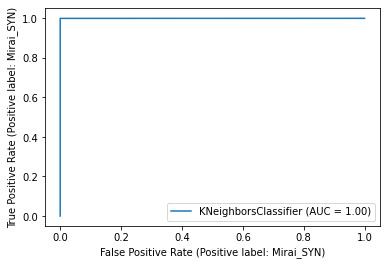

In [246]:
plot_roc_curve(cv.best_estimator_, X_test, y_test)
plt.show() 